In [1]:
import os
import itertools
import gc
import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb
import random
from IPython.display import HTML

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import keras
from keras import initializers
from keras.layers import Input, Embedding, Dense, Flatten, Dropout
from keras.models import Model
from keras.layers.merge import concatenate

import matplotlib.pyplot as plt

%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Utility Functions

In [2]:
# For pulling in input data
class DataLoader:
    def __init__(self):
        self.props = pd.DataFrame()
        self.train = pd.DataFrame()
        self.subm = pd.DataFrame()
        self.train_file = 'train_2016_v2'
        self.props_file = 'properties_2016'
        self.subm_file = 'sample_submission'
    
    def load_file(self, f):
        pkl = os.path.join('zillow', f + '.pkl')
        if os.path.exists(pkl):
            df = pd.read_pickle(pkl)
        else:
            csv = os.path.join('zillow', f + '.csv')
            df = pd.read_csv(csv)
            df.to_pickle(pkl)
        return df

    def get_properties(self):
        if self.props.empty:
            self.props = self.load_file(self.props_file)
        return self.props
    
    def get_training(self):
        if self.train.empty:
            self.train = self.load_file(self.train_file)
        return self.train
    
    def get_submission(self):
        if self.subm.empty:
            self.subm = self.load_file(self.subm_file)
        return self.subm
    
dl = DataLoader()
    
# generator function for pulling out items a number at a time
def batch(s, n):
    for i in range(0, len(s), n):
        yield s[i:min(i+n, len(s))]
        
# test function
# display(props.columns)
# [c for c in batch(props.columns, 6)]

# for describing the data with DataFrameSummary
def summarize(df):
    for cols in batch(df.columns, 5):
        display(pds.DataFrameSummary(df[cols]).summary())
        
# test function
# describe(props)

# for showing data types, unique and missing values
def describe_values(df):
    stats = pd.DataFrame(columns=['column', 'dtype', 'sample', 'unique len', 'missing %'])
    for c in df.columns:
        uniques = df[c].unique()
        if uniques.dtype == np.float64:
            uniques = np.sort(uniques)
        stats.loc[-1] = [c, df[c].dtype, uniques[:3], len(uniques), df[c].isnull().sum(axis=0) / df[c].size * 100]
        stats.index += 1
    display(stats.set_index('column'))

# Training & Testing w/ XGBoost

In [79]:
# utility function for splitting the date into components
def split_date(df, datecol):
    df[datecol] = pd.to_datetime(df[datecol])
    df[datecol+'_year'] = df[datecol].dt.year
    df[datecol+'_month'] = df[datecol].dt.month
#     df[datecol+'_week'] = df[datecol].dt.week
#     df[datecol+'_day'] = df[datecol].dt.day
#     df[datecol+'_dayofweek'] = df[datecol].dt.dayofweek
    return df


def add_age(df):
    df['age'] = (df['transactiondate_year'] - 2016) * 12 + df['transactiondate_month']
    return df


def remove_outliers(X, y):
    f = np.abs(y-y.mean())<=(3*y.std())
    return X[f], y[f]


def train_test_split(X, y, month=10):
    c = X.transactiondate_month
    return X[c < month], X[c == month], X[c > month], y[c < month], y[c == month], y[c > month]

    
def xgb_train(props, params=None):
    train = dl.get_training()
    
    train = split_date(train, 'transactiondate')
    train = train.merge(props, how='left', on='parcelid')
    train = add_age(train)

    X = train.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
    y = train['logerror']
    
    del train; gc.collect()
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = train_test_split(X, y)
#     x_train, y_train = remove_outliers(x_train, y_train)

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)
    d_test = xgb.DMatrix(x_test, label=y_test)
    
    del x_train, x_valid, x_test; gc.collect()

    if not params:
        params = {
            'eta': 0.02,
            'objective': 'reg:linear',
            'eval_metric': 'mae',
#             'objective': 'binary:logistic',
#             'eval_metric': 'logloss',        
            'max_depth': 4,
            'silent': 1,
            'subsample': 0.5,
            'colsample_bytree': 0.4,
            'min_child_weight': 4,
            'lambda': 2,
#             'alpha': 1,
        }

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=20)
    mae = mean_absolute_error(y_test, clf.predict(d_test))
    print ("Test MAE: ", mae)
    
    del d_train, d_valid, d_test; gc.collect()
    
    return clf


def xgb_predict(clf, props):
    sample = dl.get_submission()
    
    # build the test set
    subm = pd.DataFrame()

    tx = 'transactiondate'
#     dates = pd.date_range('2016-10-01', '2016-12-31').append(pd.date_range('2017-10-01', '2017-12-31'))
    dates = pd.to_datetime(['2016-10-01', '2016-11-01', '2016-12-01', '2017-10-01', '2017-11-01', '2017-12-01'])
    for date in dates:
        display('Predicting...', date)

        batch = pd.DataFrame()
        batch['parcelid'] = sample['ParcelId']

        batch[tx] = date
        batch = split_date(batch, tx)
        
        merged = batch.merge(props, on='parcelid', how='left')
        merged = add_age(merged).drop(['parcelid', tx], axis=1)        
        
        dm_test = xgb.DMatrix(merged)
        del merged; gc.collect()
        
        batch['logerror'] = clf.predict(dm_test)
        del dm_test; gc.collect()
        
        subm  = subm.append(batch.drop(tx, axis=1))
        del batch; gc.collect()

    subm = subm.groupby(['parcelid', tx+'_year', tx+'_month']).mean()
    subm = subm.pivot_table(index='parcelid', columns=['transactiondate_year', 'transactiondate_month'], values='logerror')
#     subm = np.log(subm)
    cols = ["{}{}".format(*c) for c in subm.columns]
    subm.reset_index(inplace=True)
    subm.columns = ['ParcelId'] + cols
#     subm.rename(index="ParcelId")
    display(subm)
    subm.to_csv('zillow/submission.csv.gz', index=False, float_format='%.4f', compression='gzip')
    return subm

    
def xgb_importance(clf):
    importance = clf.get_fscore()
    importance = sorted(importance.items(), key=lambda x: x[1])

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    
    
# train a model
def train_predict(props, params=None, predict=False):
    clf = xgb_train(props, params)
    xgb_importance(clf)
    subm = None
    if predict:
        subm = xgb_predict(clf, props)
    return clf, subm

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[0]	train-mae:0.488061	valid-mae:0.479344
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.332755	valid-mae:0.323957
[40]	train-mae:0.231419	valid-mae:0.222932
[60]	train-mae:0.166343	valid-mae:0.158495
[80]	train-mae:0.125184	valid-mae:0.11783
[100]	train-mae:0.10006	valid-mae:0.092917
[120]	train-mae:0.085355	valid-mae:0.078513
[140]	train-mae:0.077231	valid-mae:0.070821
[160]	train-mae:0.072916	valid-mae:0.066963
[180]	train-mae:0.070637	valid-mae:0.065013
[200]	train-mae:0.069442	valid-mae:0.064085
[220]	train-mae:0.068804	valid-mae:0.063663
[240]	train-mae:0.068442	valid-mae:0.063475
[260]	train-mae:0.068231	valid-mae:0.063372
[280]	train-mae:0.068104	valid-mae:0.063339
[300]	train-mae:0.068018	valid-mae:0.063337
[320]	train-mae:0.067955	valid-mae:0.063322
[340]	train-mae:0.067916	valid-mae:0.063331
[360]	train-mae:0.067878	valid-mae:0.063329
[380]	train-mae:0.06787	vali

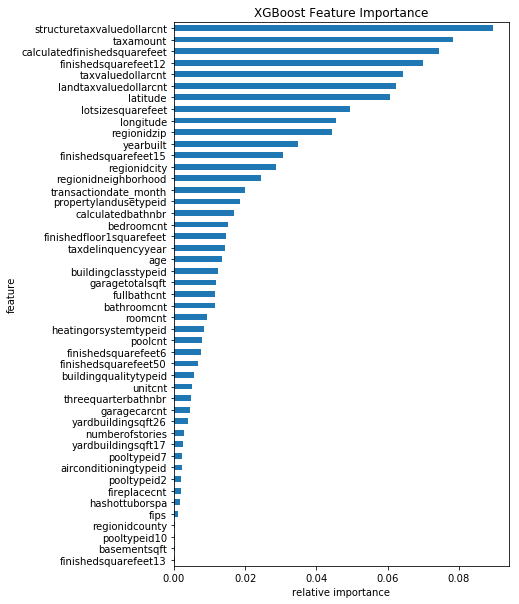

In [4]:
props = dl.get_properties()
df = props.drop(['propertyzoningdesc', 
                 'propertycountylandusecode', 
                 'censustractandblock', 
                 'rawcensustractandblock'
                ], axis=1)

for c in df.dtypes[df.dtypes == object].index.values:
    df[c] = (df[c] == True)

clf, subm = train_predict(df)

## Baseline MAE = 0.0684537443667

# Data Prep

We're going to prep data for input into a NN. That means no NaNs and we have to mark the categorical features. Categories will be fed into an embedding layer.

In [5]:
DEFAULT_CATEGORY = ''
CATEGORY_TYPE = 'str'
DEFAULT_NUMERIC = 0

props = dl.get_properties()
procd = pd.DataFrame()

In [6]:
# if it doesn't have a value, we just get it from bathroomcnt
c = 'calculatedbathnbr'
procd[c] = props[c].fillna(props['bathroomcnt'])
procd[c] = procd[c].fillna(DEFAULT_NUMERIC)
display(procd[c].unique())

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [7]:
# check if we can get pull data from censustractandblock into rawcensustractandblock
(props.rawcensustractandblock.isnull() & ~props.censustractandblock.isnull()).any()

False

In [8]:
c = 'rawcensustractandblock'
procd[c] = props[c].astype('str')
procd['fips'] = procd[c].str.slice(0, 4).replace('nan', DEFAULT_CATEGORY).astype(CATEGORY_TYPE)
procd['tract'] = procd[c].str.slice(4, 11).replace('', DEFAULT_CATEGORY).astype(CATEGORY_TYPE)
procd['block'] = procd[c].str.slice(11).replace('', DEFAULT_CATEGORY).astype(CATEGORY_TYPE)
procd[c] = procd[c].astype(CATEGORY_TYPE)
procd.loc[:, ('fips', 'tract', 'block')].head().transpose()

,0,1,2,3,4
fips,6037,6037,6037,6037,6037
tract,8002.04,8001.01,7030.01,1412.02,1232.05
block,1,1,2,3,2


In [9]:
# investigate yearbuilt
c = 'yearbuilt'

# df = props[['structuretaxvaluedollarcnt', c]].dropna()
# df.plot.scatter(x=c, y='structuretaxvaluedollarcnt')

# display(np.sort(procd[c].unique()))

# fill with 2016, seems to be the missing year
procd[c] = props[c].fillna(2016).astype('float32')

In [10]:
c = 'hashottuborspa'
procd[c] = props[c] == True
procd[c] = procd[c].astype('bool')

c = 'taxdelinquencyflag'
procd[c] = props[c].astype('str')
procd[c] = procd[c] == 'Y'
procd[c] = procd[c].astype('bool')

c = 'propertycountylandusecode'
procd[c] = props[c].fillna(DEFAULT_CATEGORY).astype('str').astype(CATEGORY_TYPE)

c = 'propertyzoningdesc'
procd[c] = props[c].fillna(DEFAULT_CATEGORY).astype(CATEGORY_TYPE)

c = 'censustractandblock'
procd[c] = props[c].fillna(DEFAULT_CATEGORY).astype(CATEGORY_TYPE)

In [11]:
for c in props.columns:
    if c in procd.columns:
        continue
        
    if 'typeid' in c or 'regionid' in c:
#         if (props[c] == DEFAULT_CATEGORY).any():
#             procd[c] = props[c].fillna(props[c].max() + 1)
#         else:
        procd[c] = props[c].fillna(DEFAULT_CATEGORY)
        procd[c] = procd[c].astype(CATEGORY_TYPE)
    
    elif props[c].dtype == np.object:
        procd[c] = props[c] == True
        procd[c] = procd[c].astype('bool')
    
    else:
        procd[c] = props[c]
        
    if procd[c].dtype == np.float64:
        if (props[c] == DEFAULT_NUMERIC).any():
            procd[c] = props[c].fillna(props[c].mean())
        else:
            procd[c] = props[c].fillna(DEFAULT_NUMERIC)
        procd[c] = procd[c].astype('float32')

describe_values(procd)

,dtype,sample,unique len,missing %
column,,,,
calculatedbathnbr,float64,"[0.0, 0.5, 1.0]",37,0.0
rawcensustractandblock,object,"[60378002.041, 60378001.011, 60377030.012]",8922,0.0
fips,object,"[6037, 6059, 6111]",4,0.0
tract,object,"[8002.04, 8001.01, 7030.01]",3073,0.0
block,object,"[1, 2, 3]",32,0.0
yearbuilt,float32,"[1801.0, 1805.0, 1806.0]",169,0.0
hashottuborspa,bool,"[False, True]",2,0.0
taxdelinquencyflag,bool,"[False, True]",2,0.0
propertycountylandusecode,object,"[010D, 0109, 1200]",241,0.0


Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7f3e7184fda0>>
Traceback (most recent call last):
  File "/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/xgboost/core.py", line 324, in __del__
    _check_call(_LIB.XGDMatrixFree(self.handle))
AttributeError

[0]	train-mae:0.48806	valid-mae:0.479332
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.332713	valid-mae:0.323909
[40]	train-mae:0.231415	valid-mae:0.222897
[60]	train-mae:0.166294	valid-mae:0.158348
[80]	train-mae:0.125212	valid-mae:0.11781
[100]	train-mae:0.100092	valid-mae:0.09293
[120]	train-mae:0.085395	valid-mae:0.078551
[140]	train-mae:0.077238	valid-mae:0.070867
[160]	train-mae:0.072861	valid-mae:0.066857
[180]	train-mae:0.070602	valid-mae:0.064976
[200]	train-mae:0.069409	valid-mae:0.064062
[220]	train-mae:0.068758	valid-mae:0.063668
[240]	train-mae:0.068389	valid-mae:0.063418
[260]	train-mae:0.068179	valid-mae:0.0633
[280]	train-mae:0.068024	valid-mae:0.06321
[300]	train-mae:0.067945	valid-mae:0.063213
[320]	train-mae:0.06789	valid-mae:0.063198
[340]	train-mae:0.067839	valid-mae:0.063177
[360]	train-mae:0.06782	valid-mae:0.063205
[380]	train-mae:0.067795	valid-mae

: 'DMatrix' object has no attribute 'handle'


(<xgboost.core.Booster at 0x7f3e703b6eb8>, None)

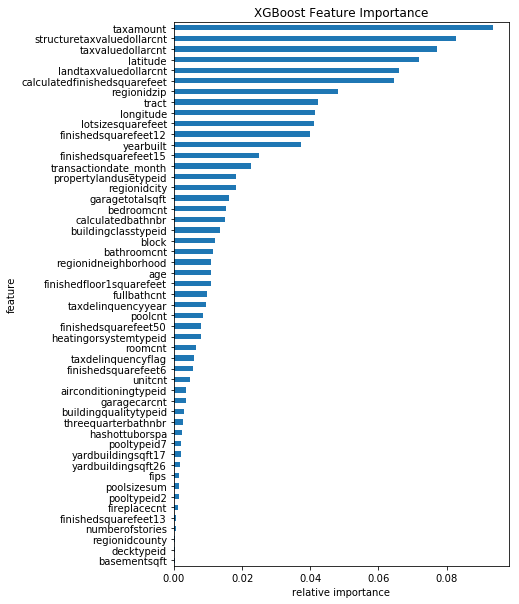

In [14]:
# Let's do one more test with xgboost to see if everything is dandy.

dropcols = [
    'propertycountylandusecode',
    'propertyzoningdesc',
    'rawcensustractandblock',
    'censustractandblock',
]

df = procd.copy()
df.drop(dropcols, axis=1, inplace = True)
for c in df.columns:
    if df[c].dtype.name == 'object':
        df[c] = df[c].replace('',0).astype(np.float32)

train_predict(df)

In [15]:
procd.to_pickle('zillow/preprocessed.pkl')

# Build the NN Model

In [16]:
gc.collect()

17333

In [43]:
procd = pd.read_pickle('zillow/preprocessed.pkl')

In [44]:
train = dl.get_training()
train = split_date(train, 'transactiondate')
train = train.merge(procd, how='left', on='parcelid')
train = add_age(train)

gc.collect()

# dropcols = ['propertycountylandusecode', 'propertyzoningdesc', 'censustractandblock']

x = train.drop(['logerror', 'transactiondate'], axis=1)
x['parcelid'] = x['parcelid'].astype(CATEGORY_TYPE)
procd['parcelid'] = procd['parcelid'].astype(CATEGORY_TYPE)
y = train['logerror']

cat_cols = [ c for c in x.columns if x[c].dtype.name == 'object' ]
con_cols = [ c for c in x.columns if x[c].dtype.name != 'object' ]

In [45]:
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
# display(cat_maps)
con_maps = [([c], StandardScaler()) for c in con_cols]
# display(con_maps)

In [46]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(procd)
# display(cat_map_fit.features)

In [47]:
con_mapper = DataFrameMapper(con_maps)
con_map_fit = con_mapper.fit(x)
# display(con_map_fit.features)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
embsz = 16

def categorical_input(fname, fclasses):
    vocsz = len(fclasses)
    inp = Input((1,), dtype='int64', name=fname+'_inp')
    out = Embedding(vocsz, embsz, input_length=1, embeddings_initializer='random_uniform')(inp)
    out = Flatten(name=fname+'_flt')(out)
    out = Dense(1, name=fname+'_den')(out)
    return inp, out

def continuous_input(fname):
    inp = Input((1,), dtype='float32', name=fname+'_inp')
    out = Dense(1, name=fname+'_den')(inp)
    return inp, out    

cat_in = [ categorical_input(f[0], f[1].classes_) for f in cat_map_fit.features ]
con_in = [ continuous_input(f[0][0]) for f in con_map_fit.features ]

den = concatenate([ o for _, o in cat_in ] + [ o for _, o in con_in ])
den = Dropout(0.02)(den)
den = Dense(1024, activation='relu', kernel_initializer='random_uniform')(den)
den = Dense(512, activation='relu', kernel_initializer='random_uniform')(den)
den = Dense(1, activation='linear')(den)

model = Model(inputs=[ i for i, _ in cat_in ] + [ i for i, _ in con_in ], outputs=[den])
model.compile('adam', 'mean_absolute_error')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
parcelid_inp (InputLayer)        (None, 1)             0                                            
____________________________________________________________________________________________________
rawcensustractandblock_inp (Inpu (None, 1)             0                                            
____________________________________________________________________________________________________
fips_inp (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
tract_inp (InputLayer)           (None, 1)             0                                            
___________________________________________________________________________________________

# Use a small sample for testing the NN

In [85]:
# get a sample
x_train, x_valid, _, y_train, y_valid, _ = train_test_split(x, y, 10)

# transform data
x_train_cat = cat_mapper.transform(x_train).astype(np.int64)
x_train_con = con_mapper.transform(x_train).astype(np.float32)

x_valid_cat = cat_mapper.transform(x_valid).astype(np.int64)
x_valid_con = con_mapper.transform(x_valid).astype(np.float32)

display(x_train_cat.shape, x_train_con.shape)
display(np.concatenate((x_train_cat, x_train_con), axis=1).shape)

x_train = np.concatenate((x_train_cat, x_train_con), axis=1)
x_valid = np.concatenate((x_valid_cat, x_valid_con), axis=1)

x_train = np.split(x_train, x_train.shape[1], axis=1)
x_valid = np.split(x_valid, x_valid.shape[1], axis=1)

del x_train_cat, x_train_con, x_valid_cat, x_valid_con; gc.collect()

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype bool was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(81733, 24)

(81733, 39)

(81733, 63)

464

In [86]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=1,
                 verbose=1, validation_data=(x_valid, y_valid))

Train on 81733 samples, validate on 4977 samples
Epoch 1/1
81733/81733 [==============================] - 356s - loss: 0.0676 - val_loss: 0.0632


# Experiments

In [124]:
def onehot(df):
    for c in df.columns:
        if df[c].dtype.name == 'category':
            if len(df[c].unique()) <= 32:
                df = df.join(pd.get_dummies(df[c], prefix=c))
            df = df.drop(c, axis=1)
    return df
            
onehot = onehot(procd)
describe_values(onehot)

,dtype,sample,unique len,missing %
column,,,,
calculatedbathnbr,float32,"[0.0, 1.0, 1.5]",35,0.0
bathroomcnt,float32,"[0.0, 0.5, 1.0]",37,0.0
yearbuilt,float32,"[1801.0, 1805.0, 1806.0]",169,0.0
hashottuborspa,bool,"[False, True]",2,0.0
taxdelinquencyflag,bool,"[False, True]",2,0.0
parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.0
basementsqft,float32,"[0.0, 20.0, 24.0]",752,0.0
bedroomcnt,float32,"[0.0, 1.0, 2.0]",21,0.0
finishedfloor1squarefeet,float32,"[0.0, 3.0, 41.0]",4605,0.0


[0]	train-mae:0.488062	valid-mae:0.479338
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.332746	valid-mae:0.323899
[40]	train-mae:0.231489	valid-mae:0.222971
[60]	train-mae:0.166337	valid-mae:0.158477
[80]	train-mae:0.125203	valid-mae:0.117874
[100]	train-mae:0.100082	valid-mae:0.093107
[120]	train-mae:0.085356	valid-mae:0.078662
[140]	train-mae:0.077273	valid-mae:0.070953
[160]	train-mae:0.072901	valid-mae:0.066969
[180]	train-mae:0.070621	valid-mae:0.065006
[200]	train-mae:0.069408	valid-mae:0.064081
[220]	train-mae:0.068764	valid-mae:0.063623
[240]	train-mae:0.068389	valid-mae:0.063377
[260]	train-mae:0.068175	valid-mae:0.063283
[280]	train-mae:0.068064	valid-mae:0.063248
[300]	train-mae:0.067985	valid-mae:0.063244
[320]	train-mae:0.06793	valid-mae:0.063259
[340]	train-mae:0.067877	valid-mae:0.063241
[360]	train-mae:0.067847	valid-mae:0.06324
[380]	train-mae:0.067824	val

'Predicting...'

Timestamp('2016-10-01 00:00:00')

'Predicting...'

Timestamp('2016-11-01 00:00:00')

'Predicting...'

Timestamp('2016-12-01 00:00:00')

'Predicting...'

Timestamp('2017-10-01 00:00:00')

'Predicting...'

Timestamp('2017-11-01 00:00:00')

'Predicting...'

Timestamp('2017-12-01 00:00:00')

,ParcelId,201610,201611,201612,201710,201711,201712
0,10711725,0.010729,0.010729,0.010729,0.010729,0.010729,0.010729
1,10711726,0.013287,0.013287,0.013287,0.013287,0.013287,0.013287
2,10711727,0.014844,0.014844,0.014844,0.014844,0.014844,0.014844
3,10711728,0.011627,0.011627,0.011627,0.011627,0.011627,0.011627
4,10711729,0.011386,0.011386,0.011386,0.011386,0.011386,0.011386
5,10711730,0.013209,0.013209,0.013209,0.013209,0.013209,0.013209
6,10711731,0.018855,0.018855,0.018855,0.018855,0.018855,0.018855
7,10711732,0.016656,0.016656,0.016656,0.016656,0.016656,0.016656
8,10711733,0.015550,0.015550,0.015550,0.015550,0.015550,0.015550
9,10711734,0.016861,0.016861,0.016861,0.016861,0.016861,0.016861


(<xgboost.core.Booster at 0x7fd599d15e48>,
           ParcelId    201610    201611    201612    201710    201711    201712
 0         10711725  0.010729  0.010729  0.010729  0.010729  0.010729  0.010729
 1         10711726  0.013287  0.013287  0.013287  0.013287  0.013287  0.013287
 2         10711727  0.014844  0.014844  0.014844  0.014844  0.014844  0.014844
 3         10711728  0.011627  0.011627  0.011627  0.011627  0.011627  0.011627
 4         10711729  0.011386  0.011386  0.011386  0.011386  0.011386  0.011386
 5         10711730  0.013209  0.013209  0.013209  0.013209  0.013209  0.013209
 6         10711731  0.018855  0.018855  0.018855  0.018855  0.018855  0.018855
 7         10711732  0.016656  0.016656  0.016656  0.016656  0.016656  0.016656
 8         10711733  0.015550  0.015550  0.015550  0.015550  0.015550  0.015550
 9         10711734  0.016861  0.016861  0.016861  0.016861  0.016861  0.016861
 10        10711735  0.013209  0.013209  0.013209  0.013209  0.013209  0.0132

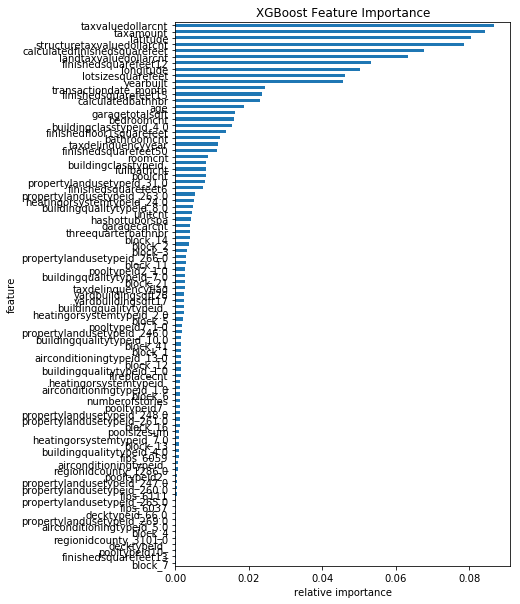

In [138]:
params = {
    'eta': 0.02,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'min_child_weight': 6,
    'max_depth': 6,
    'lambda': 2,
}

train_predict(onehot, predict=True)

In [25]:
cols = {
    'parcelid': {},
    'airconditioningtypeid': { 'fillna': 0, 'dtype': 'category' }, 
    'architecturalstyletypeid': { 'fillna': 0, 'dtype': 'category' }, 
    'basementsqft': { 'fillna': 0, 'dtype': 'float32' }, 
    'bathroomcnt': { 'fillna': 'median', 'dtype': 'float32' }, 
    'bedroomcnt': { 'fillna': 'median', 'dtype': 'float32' },
    'buildingclasstypeid': { 'fillna': 0, 'dtype': 'category' },
    'buildingqualitytypeid': { 'fillna': 0, 'dtype': 'category' },
    'calculatedbathnbr': { 'fillna': 0, 'dtype': 'float32' },
    'decktypeid': { 'fillna': 0, 'dtype': 'category' },
    'finishedfloor1squarefeet': { 'fillna': 0, 'dtype': 'float32' },
    'calculatedfinishedsquarefeet': { 'fillna': 0, 'dtype': 'float32' },
    'finishedsquarefeet12': { 'fillna': 0, 'dtype': 'float32' },
    'finishedsquarefeet13': { 'fillna': 0, 'dtype': 'float32' },
    'finishedsquarefeet15': { 'fillna': 0, 'dtype': 'float32' },
    'finishedsquarefeet50': { 'fillna': 0, 'dtype': 'float32' },
    'finishedsquarefeet6': { 'fillna': 0, 'dtype': 'float32' },
    'fips': { 'fillna': 0, 'dtype': 'category' },
    'fireplacecnt': { 'fillna': 0, 'dtype': 'float32' },
    'fullbathcnt': { 'fillna': 0, 'dtype': 'float32' },
    'garagecarcnt': { 'fillna': 'median', 'dtype': 'float32' }, 
    'garagetotalsqft', 
    'hashottuborspa',
    'heatingorsystemtypeid', 
    'latitude', 
    'longitude', 
    'lotsizesquarefeet',
    'poolcnt', 
    'poolsizesum', 
    'pooltypeid10', 
    'pooltypeid2', 
    'pooltypeid7',
    'propertycountylandusecode', 
    'propertylandusetypeid',
    'propertyzoningdesc', 
    'rawcensustractandblock', 
    'regionidcity',
    'regionidcounty', 
    'regionidneighborhood', 
    'regionidzip', 
    'roomcnt',
    'storytypeid', 
    'threequarterbathnbr', 
    'typeconstructiontypeid',
    'unitcnt', 
    'yardbuildingsqft17', 
    'yardbuildingsqft26', 
    'yearbuilt',
    'numberofstories', 
    'fireplaceflag', 
    'structuretaxvaluedollarcnt',
    'taxvaluedollarcnt', 
    'assessmentyear', 
    'landtaxvaluedollarcnt',
    'taxamount', 
    'taxdelinquencyflag', 
    'taxdelinquencyyear',
    'censustractandblock',
}

SyntaxError: invalid syntax (<ipython-input-25-38dad121e7d0>, line 6)

In [ ]:
# check if there are multiple transactions in a month

merged = train.merge(props, how='left', on='parcelid')
merged = df_train = split_date(merged, 'transactiondate')
merged.loc[merged.duplicated(['parcelid', 'transactiondate_year', 'transactiondate_month'], keep=False)]

In [ ]:
# check if all the properties are represented in the required submission

diff = set(props['parcelid']) - set(sample['ParcelId'])
display(len(diff) == 0)

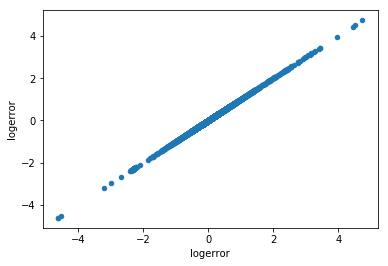

In [87]:
# check for outliers
pd.DataFrame(train['logerror']).plot.scatter(x='logerror', y='logerror')

In [90]:
summarize(pd.DataFrame(train['logerror']))

,logerror
count,90275
mean,0.0114572
std,0.161079
min,-4.605
25%,-0.0253
50%,0.006
75%,0.0392
max,4.737
counts,90275
uniques,1894


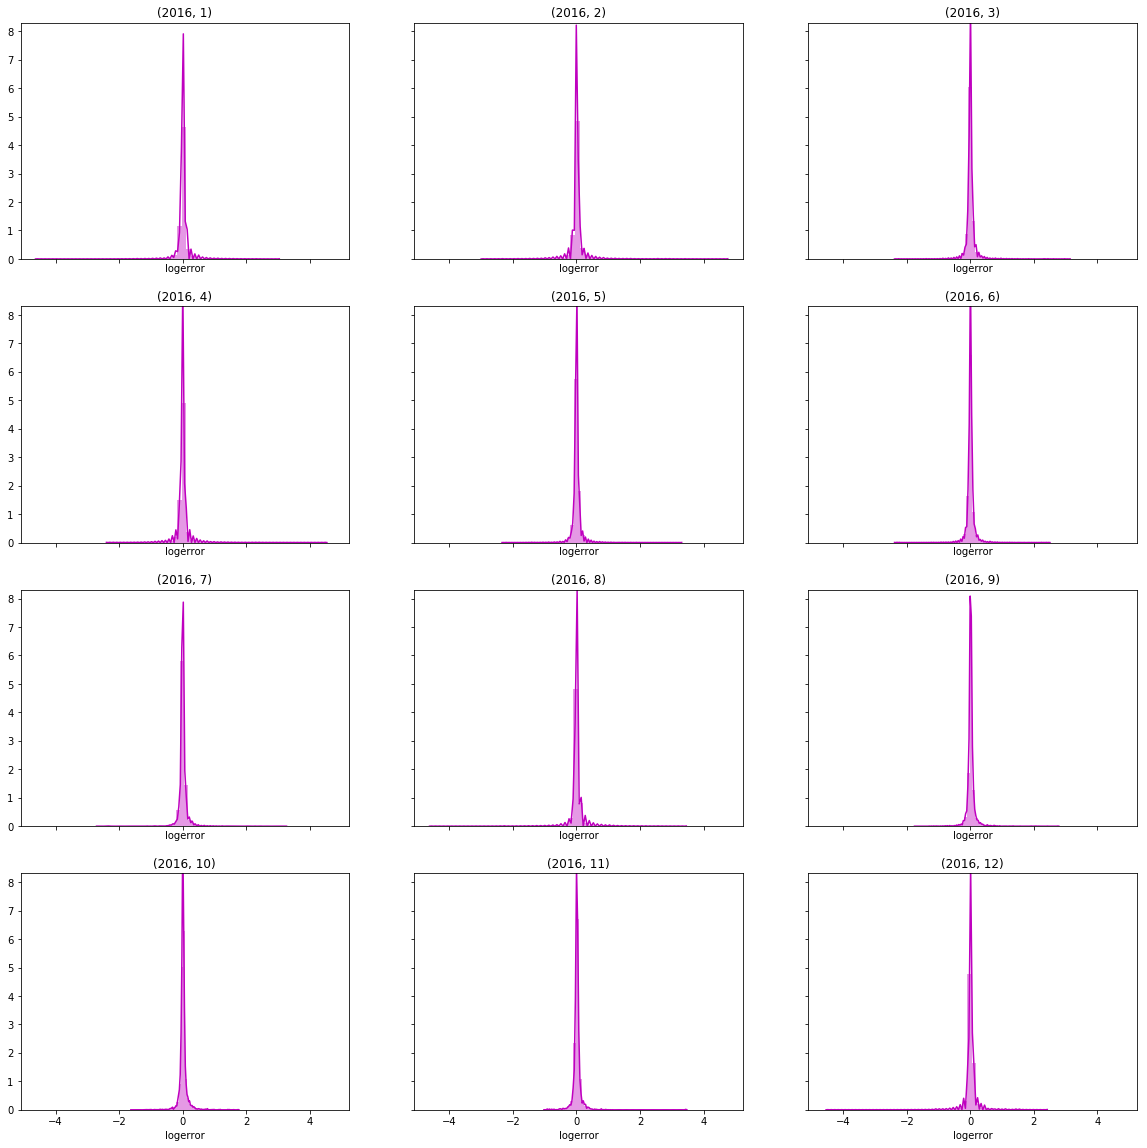

In [83]:
# see if logerror varies per month

tx = 'transactiondate'
df_train = split_date(train, tx).groupby([tx+'_year', tx+'_month'])
f, axes = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(20, 20))
for axis, (idx, df) in zip(itertools.chain(*axes), df_train):
#     axis.set(yscale="log")
#     display(axis)
#     display(df_train)
    sns.distplot(df['logerror'], color="m", ax=axis).set_title(idx)

In [49]:
area_features = [
#                  'lotsizesquarefeet', 
                 'finishedsquarefeet6', 
                 'finishedsquarefeet15', 
                 'finishedsquarefeet13', 
                 'calculatedfinishedsquarefeet', 
                 'finishedsquarefeet12', 
                 'finishedfloor1squarefeet',
                 'finishedsquarefeet50',
                ]

area_features.reverse()

def fill_null(col1, col2):
#     display("{} <== {}".format(col1, col2))
    clean[col1] = clean[col1].fillna(clean[col2])

for col in area_features:
    clean[col] = props[col]
    
# fill_null('lotsizesquarefeet', 'finishedsquarefeet15')

# describe_values(clean.loc[:, area_features])
    
# for col1, col2 in itertools.permutations(area_features, 2):
#     fill_null(col1, col2)
    
# describe_values(clean.loc[:, area_features])

# for col in area_features:
#     pad(col, clean[col].mean(), 'float32')

# describe_values(clean.loc[:, area_features])

[0]	train-mae:0.48802	valid-mae:0.480594
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[20]	train-mae:0.332731	valid-mae:0.325219
[40]	train-mae:0.231465	valid-mae:0.224249
[60]	train-mae:0.16641	valid-mae:0.159674
[80]	train-mae:0.125338	valid-mae:0.119143
[100]	train-mae:0.10027	valid-mae:0.09451
[120]	train-mae:0.08563	valid-mae:0.080356
[140]	train-mae:0.07753	valid-mae:0.072822
[160]	train-mae:0.0732	valid-mae:0.069003
[180]	train-mae:0.070928	valid-mae:0.067156
[200]	train-mae:0.069716	valid-mae:0.066286
[220]	train-mae:0.069073	valid-mae:0.065886
[240]	train-mae:0.06872	valid-mae:0.065702
[260]	train-mae:0.068519	valid-mae:0.065617
[280]	train-mae:0.068399	valid-mae:0.065578
[300]	train-mae:0.068326	valid-mae:0.065559
[320]	train-mae:0.06828	valid-mae:0.06555
[340]	train-mae:0.068251	valid-mae:0.065545
[360]	train-mae:0.068232	valid-mae:0.065542
[380]	train-mae:0.06822	valid-mae:0.0

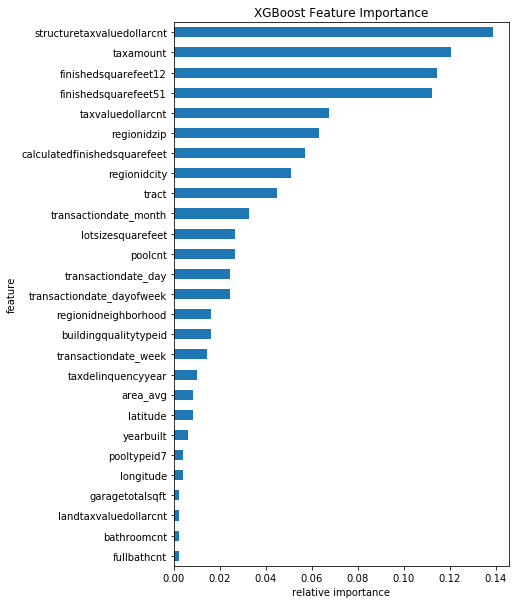

In [53]:
clean['area_avg'] = props[area_features].mean(axis=1)
clean['finishedsquarefeet12'] = props['finishedsquarefeet12']
ratio = clean['finishedsquarefeet12'].mean() / clean['lotsizesquarefeet'].mean()
clean['finishedsquarefeet51'] = clean['finishedsquarefeet12'].fillna(clean['lotsizesquarefeet'] * ratio)
# describe_values(clean)
train_predict(clean)

In [155]:
pad('regionidcity')

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

array([  37688.,   51617.,   12447.,  396054.,   47547.,      nan,
         54311.,   40227.,    5534.,   45888.,   33612.,   26964.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,   12520.,  118217.,   54212.,   45398.,   24174.,
         30267.,   21778.,   10723.,  118878.,   22827.,    5465.,
         36502.,   45602.,   39308.,   33836.,   24245.,   32923.,
         37015.,   24812.,   34780.,   52650.,   46314.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   40110.,   18098.,
         13311.,   51239.,   34037.,   47198.,   25974.,   416

In [33]:
from sklearn.neighbors import KNeighborsClassifier

def fill_with_NN(df, col):
    df_train = df[~df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    df_pred = df[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull()]
    display(df_train)
    display(df_pred)
    X = df_train.loc[:, ('longitude', 'latitude')].astype('float32')
    y = df_train[col]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X, y)
    df.loc[df[col].isnull() & ~df['latitude'].isnull() & ~df['longitude'].isnull(), (col)] = knn.predict(df_pred.loc[:, ('longitude', 'latitude')])
    display(preds)

pad('regionidcity')
pad('latitude')
pad('longitude')
fill_with_NN(clean, 'regionidcity')

describe_values(clean)
# regionidneighborhood

'regionidcity'

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

array([  37688.,   51617.,   12447.,  396054.,   47547.,   54311.,
         40227.,    5534.,   45888.,   33612.,   26964.,   12520.,
         17882.,   25953.,   33837.,   48424.,   45457.,   47019.,
         50749.,   30187.,  118994.,   47762.,    6395.,   39076.,
         16961.,   10774.,   46298.,   44116.,   27103.,   54722.,
         53027.,   33311.,   13716.,   53636.,   14634.,   39306.,
         20008.,   51861.,   11626.,   53162.,  113576.,   24384.,
         26483.,  118217.,   54212.,   45398.,   24174.,   30267.,
         21778.,   10723.,  118878.,   22827.,    5465.,   36502.,
         45602.,   39308.,   33836.,   24245.,   32923.,   37015.,
         24812.,   34780.,   52650.,   46314.,   38032.,   15554.,
         33840.,   47568.,   42967.,   27491.,   16764.,   26531.,
         25218.,   32380.,   53571.,   17150.,   13091.,   26965.,
         27110.,   34278.,   34543.,   13150.,   25468.,   42150.,
         40110.,   18098.,   13311.,   51239.,   34037.,   471

'latitude'

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

array([ 34144442.,  34140430.,  33989359., ...,  33525063.,  33634876.,
              nan])

'longitude'

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

array([ -1.18654084e+08,  -1.18625364e+08,  -1.18394633e+08, ...,
        -1.18845451e+08,  -1.17801513e+08,              nan])

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.76,NaN,NaN,NaN


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [262]:
for c in cat_cols:
    merged[c] = merged[c].astype('str')
    merged[c].fillna("")
    merged[c] = merged[c].astype('category')
for c in cont_cols: 
    merged.loc[merged[c].isnull(), c] = 0
    
#describe(merged)

In [263]:
#see if all properties have test data
subm = pd.read_csv('zillow/sample_submission.csv')

# describe(subm)

In [264]:
# see how much training data we have

# total props in submission
display(subm['ParcelId'].count())

# submission vs property data
display(subm[~subm['ParcelId'].isin(props['parcelid'])]['ParcelId'].count())

# submission vs training data
display(subm[~subm['ParcelId'].isin(train['parcelid'])]['ParcelId'].count())

2985217

0

2895067

In [265]:
X = merged.drop(drop_cols, axis=1)
X = merged.drop('logerror', axis=1)
y = merged['logerror']

cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cont_maps = [([c], StandardScaler()) for c in cont_cols]

cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(X)
len(cat_map_fit.features)

cont_mapper = DataFrameMapper(cont_maps)
cont_map_fit = cont_mapper.fit(X)
len(cont_map_fit.features)

X_cat = cat_mapper.transform(X).astype(np.int64)
X_cont = cont_mapper.transform(X).astype(np.float32)

In [270]:
X_all = np.concatenate([X_cat, X_cont], axis=1)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1)

In [272]:
train = xgboost.DMatrix(X_train, y_train, feature_names=cat_cols + list(cont_cols))
test = xgboost.DMatrix(X_test, y_test, feature_names=cat_cols + list(cont_cols))

In [285]:
xgb_parms = {'eta': 0.01, 'max_depth': 6, 'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': 1}

In [286]:
xgb_parms['seed'] = random.randint(0,1e9)
watchlist = [(train, 'train'), (test, 'test')]
xgbmodel = xgboost.train(xgb_parms, train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=50)

[0]	train-mae:0.492253	test-mae:0.490514
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[50]	train-mae:0.306081	test-mae:0.304423
[100]	train-mae:0.196957	test-mae:0.195456
[150]	train-mae:0.134524	test-mae:0.133135
[200]	train-mae:0.100185	test-mae:0.098941
[250]	train-mae:0.082543	test-mae:0.081343
[300]	train-mae:0.074129	test-mae:0.073052
[350]	train-mae:0.070293	test-mae:0.069268
[400]	train-mae:0.068527	test-mae:0.067582
[450]	train-mae:0.067659	test-mae:0.066816
[500]	train-mae:0.067184	test-mae:0.066461
[550]	train-mae:0.066905	test-mae:0.066294
[600]	train-mae:0.06671	test-mae:0.066228
[650]	train-mae:0.066561	test-mae:0.066205
[700]	train-mae:0.066428	test-mae:0.066199
[750]	train-mae:0.066313	test-mae:0.066208
[800]	train-mae:0.066198	test-mae:0.066253
Stopping. Best iteration:
[732]	train-mae:0.066353	test-mae:0.066193



In [287]:
xgbmodel.eval(test)

b'[0]\teval-mae:0.066267'